In [1]:
import codecs
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error

In [2]:
def read_data(fin, delim):
    info_li = []

    for line in codecs.open(fin,"r",encoding="latin-1"):
        line_items = line.strip().split(delim)
        #print(line_items)

        key = int(line_items[0])
        if (len(info_li)+1)!=key:
            print('errors at data_id')
            exit(0)
        info_li.append(line_items[1:])
        
    print('rows in %s: %d'%(fin, len(info_li)))


    return(info_li)

In [3]:
fin_user= "u.user"
fin_movie= "u.item"
fin_rating= "u.data"

In [4]:
user_info_li = read_data(fin_user,'|')
movie_info_li = read_data(fin_movie,'|')

rows in u.user: 943
rows in u.item: 1682


In [5]:
def read_rating_data(fin):

    Q = np.zeros((len(user_info_li), len(movie_info_li)), dtype=np.float64)

    for line in open(fin):
        user, movie, rating, date = line.strip().split("\t")
        user_index = int(user)-1
        movie_index = int(movie)-1

        Q[user_index,movie_index]= float(rating)

    return(Q)

In [6]:
R=read_rating_data(fin_rating)

In [7]:
user_mean_li=[]
for i in range(0,R.shape[0]):
    user_rating = [x for x in R[i] if x>0.0]
    user_mean_li.append(stats.describe(user_rating).mean)

In [8]:
stats.describe(user_mean_li)

DescribeResult(nobs=943, minmax=(1.4919540229885058, 4.8695652173913047), mean=3.5881911071848003, variance=0.19823286521146211, skewness=-0.44416521432016465, kurtosis=0.9286813229088393)

In [9]:
movie_mean_li=[]
for i in range(0,R.shape[1]):
    R_T = R.T
    movie_rating = [x for x in R_T[i] if x>0.0]
    movie_mean_li.append(stats.describe(movie_rating).mean)

/home/pukekakaster/app/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/pukekakaster/app/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [10]:
stats.describe(movie_mean_li)

DescribeResult(nobs=1682, minmax=(1.0, 5.0), mean=3.0760445083251788, variance=0.61099475027975136, skewness=-0.6991282361538707, kurtosis=0.4442028070725441)

In [11]:
def compute_GD(R,n_iter, lambda_, learning_rate, k):
    m,n =R.shape
    errors=[]
        
    X = np.random.rand(m, k)
    Y = np.random.rand(k, n)
    
    for ii in range(n_iter):
        for u in range(m):
            for i in range(n):
                if R[u,i]>0:
                    e_ui = R[u,i]-np.dot(X[u, :], Y[:,i])

                    X[u,:] = X[u,:] + learning_rate * (e_ui* Y[:,i] - lambda_ * X[u,:])
                    Y[:,i] = Y[:,i] + learning_rate * (e_ui * X[u,:] - lambda_ * Y[:,i])  
                    
        errors.append(mean_squared_error(R, np.dot(X, Y)))
        
        if ii % 10 == 0:
            print('iteration %d is completed'%(ii))

    R_hat = np.dot(X, Y)
    print('Error of rated movies: %.5f'%(mean_squared_error(R, R_hat)))

    return(R_hat, errors)

In [12]:
R_hat, errors= compute_GD(R,20, 1, 0.001, 100)

iteration 0 is completed
iteration 10 is completed
Error of rated movies: 25.87565


In [13]:
R_hat, errors= compute_GD(R,40, 1, 0.001, 100)

iteration 0 is completed
iteration 10 is completed
iteration 20 is completed
iteration 30 is completed
Error of rated movies: 17.67970


In [14]:
def train_test_split(R, n_test):
    train = R.copy()
    test = np.zeros(R.shape)
    for user in range(R.shape[0]):
        test_index = np.random.choice(R[user, :].nonzero()[0], size=n_test, replace=False)
        train[user, test_index] = 0.
        test[user, test_index] = R[user, test_index]

    return (train, test)

In [15]:
def get_test_mse(true,pred):
    pred = pred[true.nonzero()].flatten()
    true = true[true.nonzero()].flatten()
    return mean_squared_error(true,pred)

In [16]:
from sklearn.metrics import mean_squared_error
import numpy as np

def compute_ALS(R, test, n_iter, lambda_, k):
    m,n =R.shape
    X = np.random.rand(m, k)
    Y = np.random.rand(k, n)
    errors =[]
    # 갱신 시마다 계산한 에러를 저장합니다.
    for i in range(0, n_iter):
        X = np.linalg.solve(np.dot(Y, Y.T) + lambda_ * np.eye(k),np.dot(Y, R.T)).T
        Y = np.linalg.solve(np.dot(X.T, X) + lambda_ * np.eye(k), np.dot(X.T, R))
        errors.append(get_test_mse(test,np.dot(X, Y)))

        if i % 10 == 0:
            print('iteration %d is completed'%(i))
    
    R_hat = np.dot(X, Y)
    print('Error of rated movies: %.5f'%(get_test_mse(test,R_hat)))
    return(R_hat, errors)

In [17]:
train,test = train_test_split(R, 10)

In [18]:
R_hat, train_errors = compute_ALS(train, train,20, 0.1,100)

iteration 0 is completed
iteration 10 is completed
Error of rated movies: 2.38620


In [19]:
R_hat, test_errors = compute_ALS(train, test,20, 0.1,100)

iteration 0 is completed
iteration 10 is completed
Error of rated movies: 10.02028


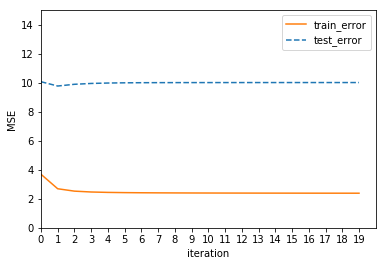

In [20]:
from matplotlib import pyplot as plt

x=range(0,20)

plt.xlim(0,20) # x축의 표시 범위를 0-20까지 설정(20은 반복 횟수입니다)
plt.ylim(0,15) # y축의 표시 범위를 0-15까지 설정
plt.xlabel('iteration')
plt.ylabel('MSE')
plt.xticks(x, range(0,20)) # x축에 표시할 숫자를 0부터 19까지의 정수로 함
# 평가 에러를 점선으로 표시
test_plot, = plt.plot(x,test_errors, '--', label='test_error')
# 학습 에러를 실선으로 표시
train_plot, = plt.plot(x,train_errors, label='train_error')
plt.legend(handles=[train_plot, test_plot]) # 범례 생성
plt.show()

In [21]:
R_hat, train_errors = compute_ALS(train, train,20, 50,100)
R_hat, test_errors = compute_ALS(train, test,20, 50,100)

iteration 0 is completed
iteration 10 is completed
Error of rated movies: 5.46726
iteration 0 is completed
iteration 10 is completed
Error of rated movies: 9.08380


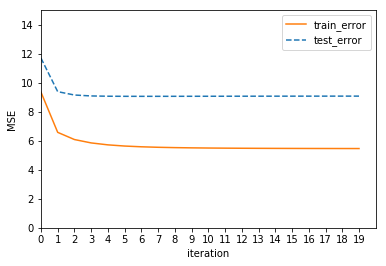

In [22]:
plt.clf()
from matplotlib import pyplot as plt

x=range(0,20)

plt.xlim(0,20) # x축의 표시 범위를 0-20까지 설정(20은 반복 횟수입니다)
plt.ylim(0,15) # y축의 표시 범위를 0-15까지 설정
plt.xlabel('iteration')
plt.ylabel('MSE')
plt.xticks(x, range(0,20)) # x축에 표시할 숫자를 0부터 19까지의 정수로 함
# 평가 에러를 점선으로 표시
test_plot, = plt.plot(x,test_errors, '--', label='test_error')
# 학습 에러를 실선으로 표시
train_plot, = plt.plot(x,train_errors, label='train_error')
plt.legend(handles=[train_plot, test_plot]) # 범례 생성
plt.show()

In [23]:
R_hat -= np.min(R_hat)

R_hat *= float(5) / np.max(R_hat)

def recommend_by_user(user):
    user_index = user-1
    user_seen_movies = sorted(list(enumerate(R_hat[user_index])),key=lambda x:x[1], reverse=True)
    recommended=1
    print("-----recommendation for user %d------"%(user))
    for movie_info in user_seen_movies:
        if W[user][movie_info[0]]==0:
            movie_title= movie_info_li[int(movie_info[0]+1)]
            movie_score= movie_info[1]
            print("rank %d recommendation:%s(%.3f)"%(recommended,movie_title[0], movie_score))
            recommended+=1
        if recommended==6:
            break

In [25]:
W = R>0.0
W[W == True] = 1
W[W == False] = 0
W = W.astype(np.float64, copy=False)

In [26]:
recommend_by_user(1)

-----recommendation for user 1------
rank 1 recommendation:So I Married an Axe Murderer (1993)(3.748)
rank 2 recommendation:Wrong Trousers, The (1993)(3.741)
rank 3 recommendation:Raiders of the Lost Ark (1981)(3.694)
rank 4 recommendation:Priest (1994)(3.621)
rank 5 recommendation:Brazil (1985)(3.558)
